In [1]:
%load_ext autoreload
%autoreload 2

In [18]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import refnis_to_arrondissment, get_arrondissement_from_code, prov_to_region
from utils import arrond_to_prov, get_ref_df
from place_name_mappings import col_names


import geopandas as gpd

pd.set_option('display.max_colwidth', 200)
pd.set_option("display.precision", 2)

In [3]:
def weighted_avg(series, weights):
    mask = ~series.isna()
    series_valid = series[mask]
    weights_valid = weights[mask]
    
    wsum = weights_valid.sum()
    if wsum == 0 or np.isnan(wsum):
        return np.nan
    return (series_valid * weights_valid).sum() / wsum

def make_weighted(col, n_col):
    return lambda g: weighted_avg(g[col], g[n_col])

def weighted_agg(group):
    return pd.Series({
        "n_1": group["n_1"].sum(),
        "n_2": group["n_2"].sum(),
        "n_3": group["n_3"].sum(),
        "q1_1": weighted_avg(group["q1_1"], group["n_1"]),
        "q2_1": weighted_avg(group["q2_1"], group["n_1"]),
        "q3_1": weighted_avg(group["q3_1"], group["n_1"]),
        "q1_2": weighted_avg(group["q1_2"], group["n_2"]),
        "q2_2": weighted_avg(group["q2_2"], group["n_2"]),
        "q3_2": weighted_avg(group["q3_2"], group["n_2"]),
        "q1_3": weighted_avg(group["q1_3"], group["n_3"]),
        "q2_3": weighted_avg(group["q2_3"], group["n_3"]),
        "q3_3": weighted_avg(group["q3_3"], group["n_3"]),
    })

In [4]:
excell_file = "FR_immo_statbel_trimestre_par_commune.xlsx"
sheet       = "Par commune"
df          = get_ref_df(excell_file,sheet)

df["arrond"]         = df.refnis.apply(refnis_to_arrondissment)
df["arrondissement"] = df.arrond.apply(get_arrondissement_from_code)
df["province"]       = df.arrond.apply(arrond_to_prov)
df["region"]         = df.province.map(prov_to_region)

df.drop(["n_0","q1_0", "q2_0", "q3_0"],axis=1, inplace=True)


In [5]:
df.head()

,refnis,commune,year,period,n_1,q2_1,q1_1,q3_1,n_2,q2_2,q1_2,q3_2,n_3,q2_3,q1_3,q3_3,arrond,arrondissement,province,region
0,11001,AARTSELAAR,2010,Q1,25,247000,220000,265000,4,NaN,NaN,NaN,9,NaN,NaN,NaN,11,ARRONDISSEMENT D'ANVERS,10000,02000
1,11001,AARTSELAAR,2010,Q2,20,251250,209000,275000,5,NaN,NaN,NaN,11,NaN,NaN,NaN,11,ARRONDISSEMENT D'ANVERS,10000,02000
2,11001,AARTSELAAR,2010,Q3,18,250000,230000,275000,3,NaN,NaN,NaN,9,NaN,NaN,NaN,11,ARRONDISSEMENT D'ANVERS,10000,02000
3,11001,AARTSELAAR,2010,Q4,21,245000,205000,280000,7,NaN,NaN,NaN,13,NaN,NaN,NaN,11,ARRONDISSEMENT D'ANVERS,10000,02000
4,11001,AARTSELAAR,2011,Q1,18,280000,220000,360000,5,NaN,NaN,NaN,10,NaN,NaN,NaN,11,ARRONDISSEMENT D'ANVERS,10000,02000


In [6]:
def get_quarter_time(row):
    return row.year + {"Q1":0.0, "Q2":0.25,"Q3":0.5,"Q4":0.75}[row.period]

df["time"] = df[["year", "period"]].apply(get_quarter_time,axis=1)

In [7]:
def plot_agg_vs_time(df, col, time_cat, geo_name, ax):
    if geo_name in df.commune.drop_duplicates().to_list():
        df = df.loc[df.commune==geo_name, ["time", col]].dropna().copy()
        ax.plot(df.time,df[col],marker="o", label=geo_name)
        ax.set_xlabel("year")
        ax.set_ylabel(col_names[col])
        ax.set_title(geo_name)

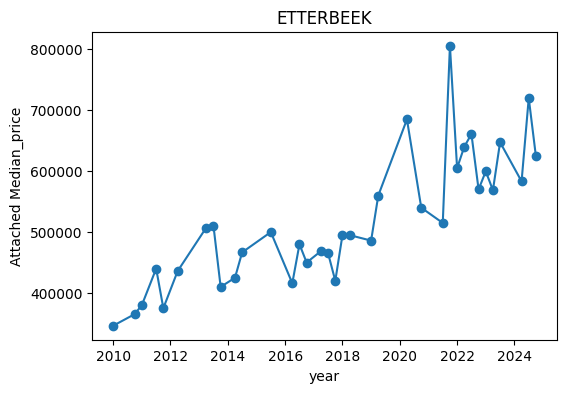

In [8]:
fig, ax = plt.subplots(figsize=(6,4))  # create figure and axis

plot_agg_vs_time(df, "q2_1", "_", "ETTERBEEK", ax)

In [9]:
cols_to_group = [ "n_1","q1_1","q2_1", "q3_1", "n_2", "q1_2", "q2_2", "q3_2", "n_3", "q1_3", "q2_3", "q3_3"]
regions = (
    df
    .groupby(["region","year"],group_keys=False)[cols_to_group]
    .apply(weighted_agg)
    .reset_index()
    .sort_values(by="year")
)
regions.head()

,region,year,n_1,n_2,n_3,q1_1,q2_1,q3_1,q1_2,q2_2,q3_2,q1_3,q2_3,q3_3
0,02000,2010,33288.0,14456.0,15822.0,142867.38,182159.47,228719.47,221556.60,2.87e+05,3.76e+05,116907.61,154635.05,208631.76
16,03000,2010,19543.0,9414.0,3502.0,91473.14,122205.48,156203.01,178412.37,2.34e+05,2.98e+05,83581.13,112638.84,147826.75
32,04000,2010,2046.0,124.0,7498.0,260346.01,332528.39,440971.34,510000.00,8.58e+05,1.44e+06,128298.96,169631.58,227626.00
17,03000,2011,20351.0,9625.0,4073.0,92028.40,124764.38,159351.93,185290.74,2.40e+05,3.06e+05,94270.43,123439.54,159267.80
33,04000,2011,2116.0,124.0,8277.0,276657.15,348229.99,474297.25,883243.24,1.13e+06,1.64e+06,131814.47,175003.33,235931.52


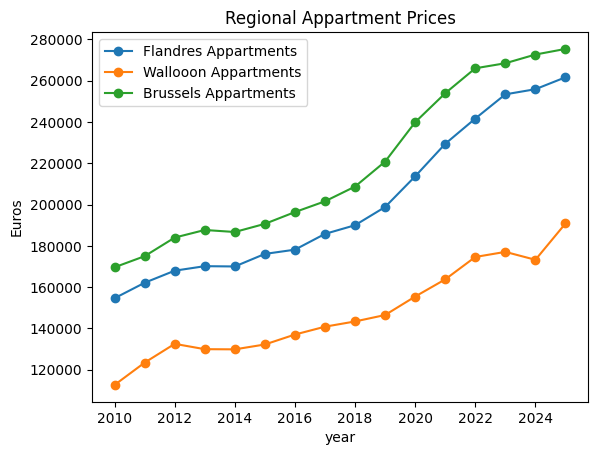

In [10]:
flandres = regions[regions.region=="02000"]
wallonia = regions[regions.region=="03000"]
brussels = regions[regions.region=="04000"]

col = "q2_3"

plt.plot(flandres.year,flandres[col],marker="o", label="Flandres Appartments")
plt.xlabel("year")
plt.ylabel("Euros")
plt.title("Regional Appartment Prices");


plt.plot(wallonia.year,wallonia[col],marker="o", label="Wallooon Appartments")
plt.xlabel("year")
plt.ylabel("Euros")
plt.title("Regional Appartment Prices");



plt.plot(brussels.year,brussels[col],marker="o", label="Brussels Appartments")
plt.xlabel("year")
plt.ylabel("Euros")
plt.title("Regional Appartment Prices");

plt.legend();

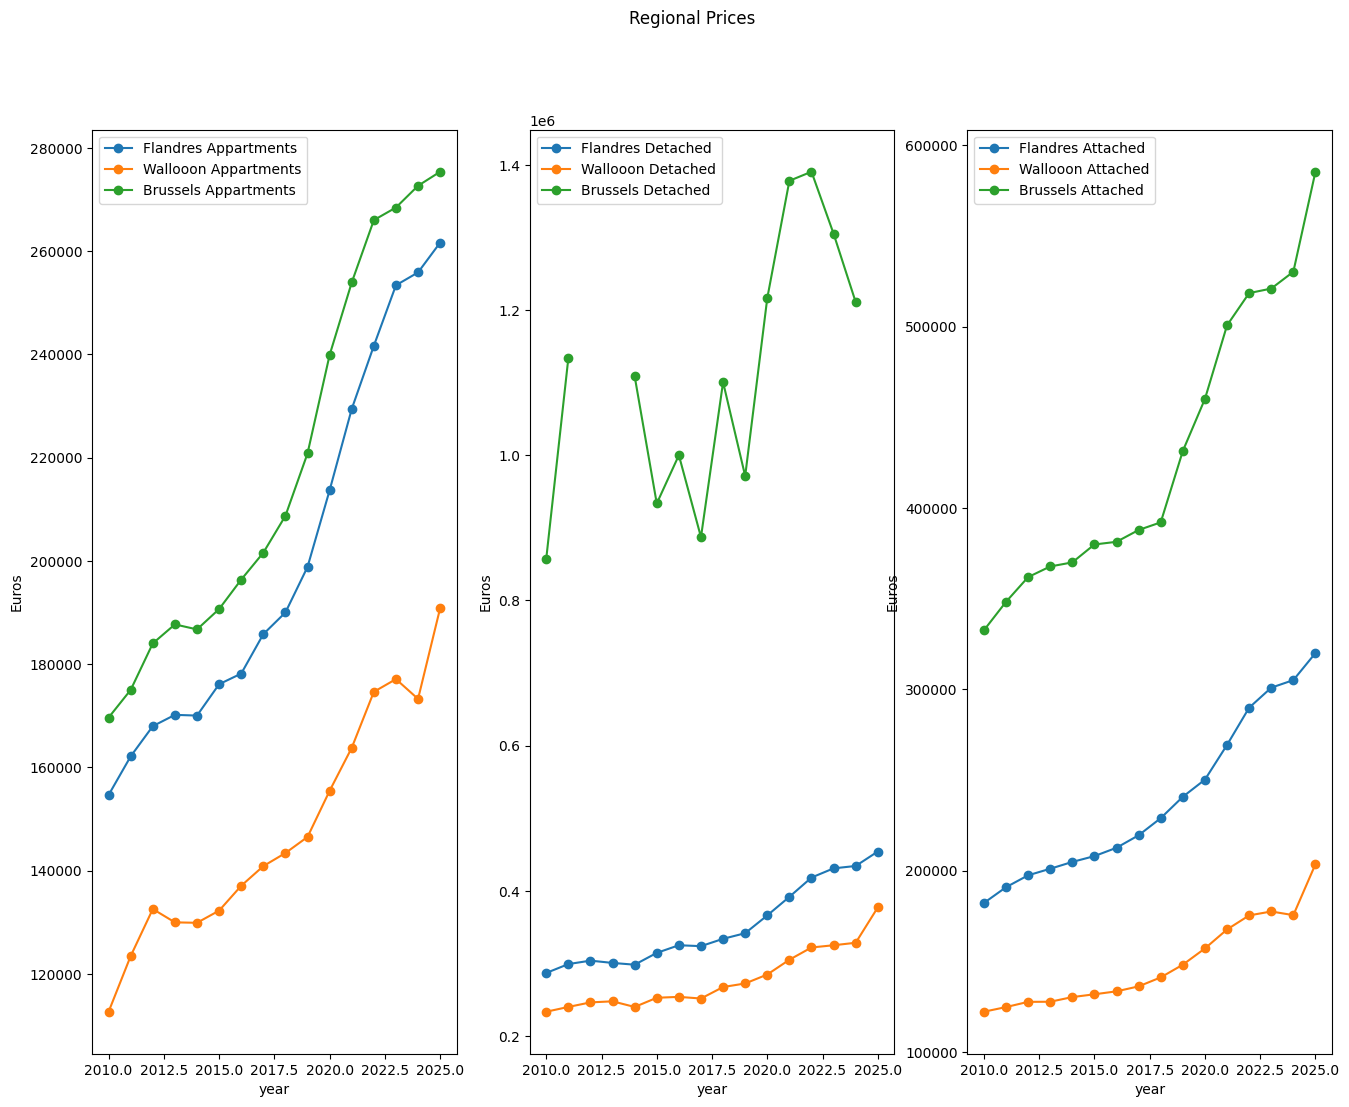

In [11]:
fig, axes = plt.subplots(1,3, figsize=(16,12))

fig.suptitle("Regional Prices");


col = "q2_3"

axes[0].plot(flandres.year,flandres[col],marker="o", label="Flandres Appartments")
axes[0].set_xlabel("year")
axes[0].set_ylabel("Euros")
axes[0].legend();


axes[0].plot(wallonia.year.astype(int),wallonia[col],marker="o", label="Wallooon Appartments")
axes[0].set_xlabel("year")
axes[0].legend();

axes[0].plot(brussels.year,brussels[col],marker="o", label="Brussels Appartments")
axes[0].set_xlabel("year")
axes[0].legend();



col = "q2_2"

axes[1].plot(flandres.year,flandres[col],marker="o", label="Flandres Detached")
axes[1].set_xlabel("year")
axes[1].set_ylabel("Euros")
axes[1].legend();


axes[1].plot(wallonia.year.astype(int),wallonia[col],marker="o", label="Wallooon Detached")
axes[1].set_xlabel("year")
axes[1].legend();

axes[1].plot(brussels.year,brussels[col],marker="o", label="Brussels Detached")
axes[1].set_xlabel("year")
axes[1].legend();


col = "q2_1"

axes[2].plot(flandres.year,flandres[col],marker="o", label="Flandres Attached")
axes[2].set_xlabel("year")
axes[2].set_ylabel("Euros")
axes[2].legend();


axes[2].plot(wallonia.year.astype(int),wallonia[col],marker="o", label="Wallooon Attached")
axes[2].set_xlabel("year")
axes[2].legend();

axes[2].plot(brussels.year,brussels[col],marker="o", label="Brussels Attached")
axes[2].set_xlabel("year")
axes[2].legend();

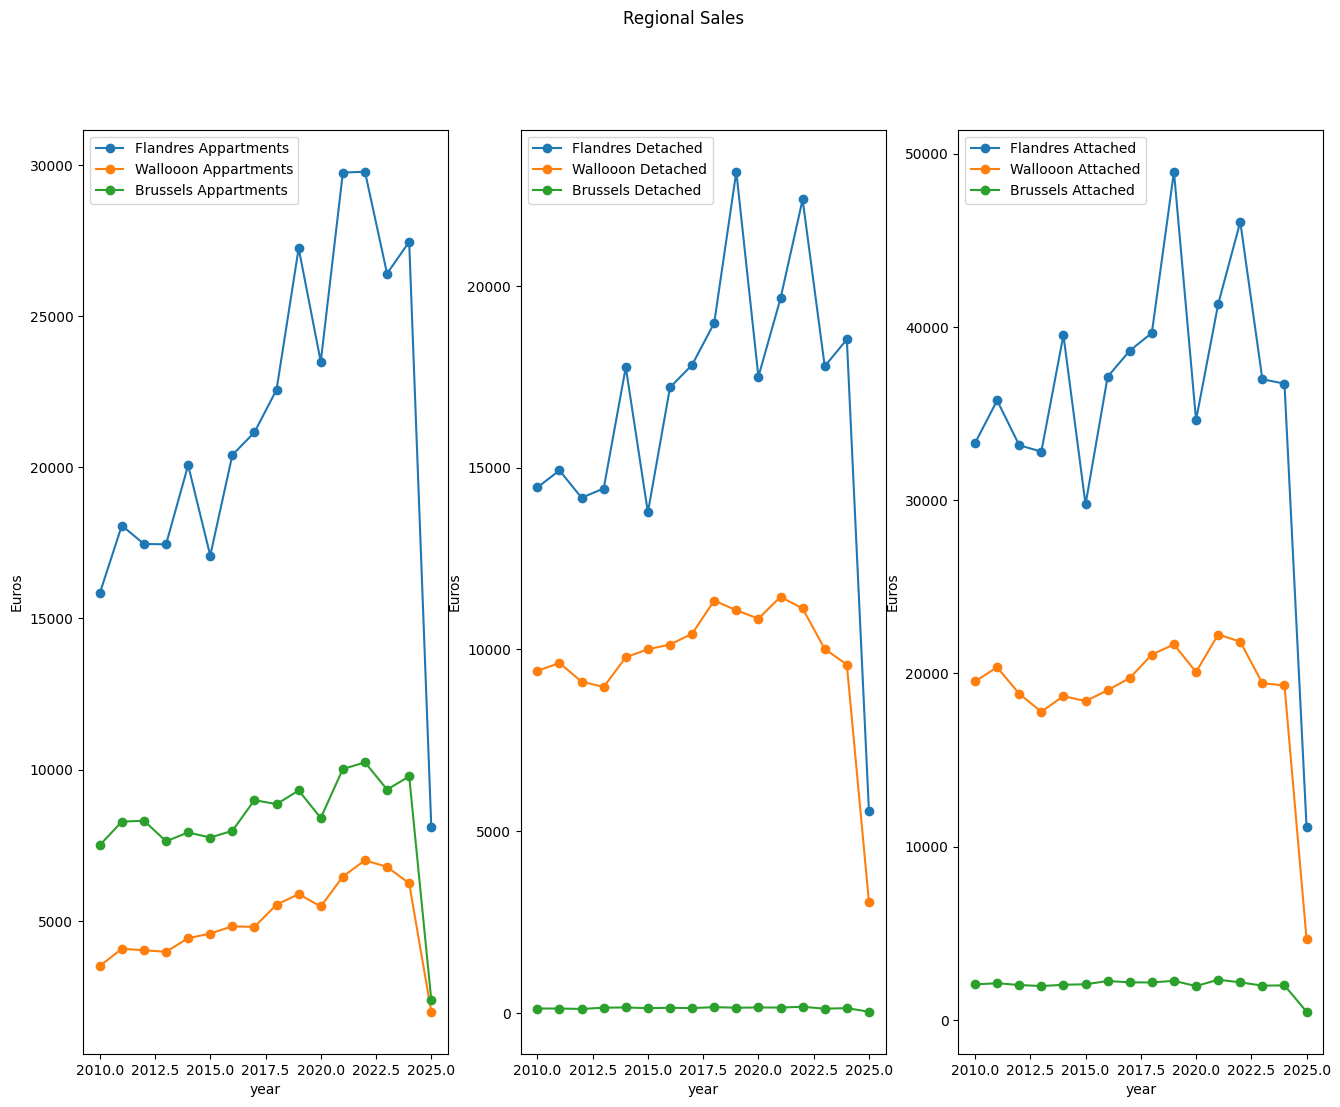

In [12]:
fig, axes = plt.subplots(1,3, figsize=(16,12))

fig.suptitle("Regional Sales");


col = "n_3"

axes[0].plot(flandres.year,flandres[col],marker="o", label="Flandres Appartments")
axes[0].set_xlabel("year")
axes[0].set_ylabel("Euros")
axes[0].legend();


axes[0].plot(wallonia.year.astype(int),wallonia[col],marker="o", label="Wallooon Appartments")
axes[0].set_xlabel("year")
axes[0].legend();

axes[0].plot(brussels.year,brussels[col],marker="o", label="Brussels Appartments")
axes[0].set_xlabel("year")
axes[0].legend();



col = "n_2"

axes[1].plot(flandres.year,flandres[col],marker="o", label="Flandres Detached")
axes[1].set_xlabel("year")
axes[1].set_ylabel("Euros")
axes[1].legend();


axes[1].plot(wallonia.year.astype(int),wallonia[col],marker="o", label="Wallooon Detached")
axes[1].set_xlabel("year")
axes[1].legend();

axes[1].plot(brussels.year,brussels[col],marker="o", label="Brussels Detached")
axes[1].set_xlabel("year")
axes[1].legend();


col = "n_1"

axes[2].plot(flandres.year,flandres[col],marker="o", label="Flandres Attached")
axes[2].set_xlabel("year")
axes[2].set_ylabel("Euros")
axes[2].legend();


axes[2].plot(wallonia.year.astype(int),wallonia[col],marker="o", label="Wallooon Attached")
axes[2].set_xlabel("year")
axes[2].legend();

axes[2].plot(brussels.year,brussels[col],marker="o", label="Brussels Attached")
axes[2].set_xlabel("year")
axes[2].legend();

# Map

In [19]:
geojson_file= Path("map_data/geojson_files/communes.geojson")

In [ ]:
import geopandas as gpd

gdf = gpd.read_file(geojson_file)

gdf.drop("geometry",axis=1).head(3)

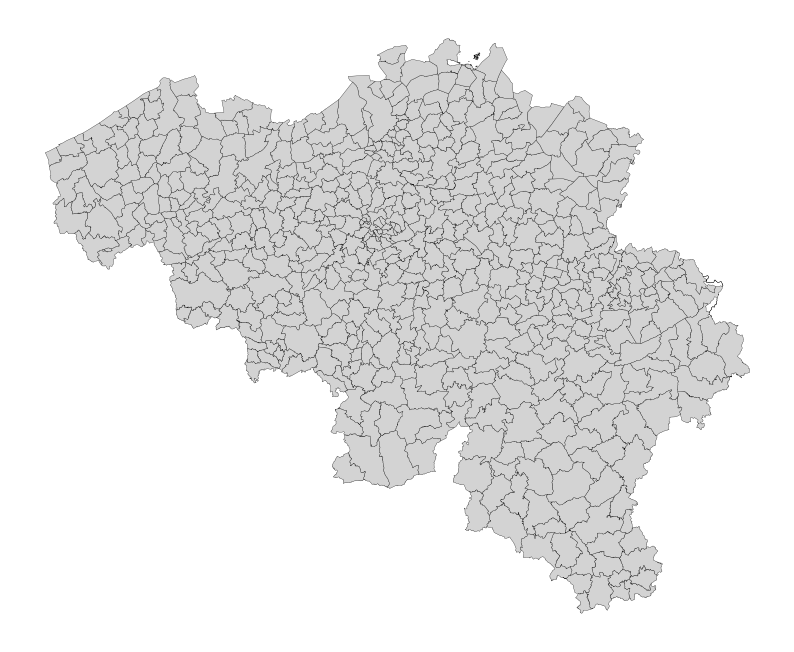

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
gdf.plot(ax=ax, facecolor="lightgrey", edgecolor="black", linewidth=0.2)
ax.set_axis_off()

# enrich gdf with prices
prices_latest_quart = df.loc[(df.year==2025) & (df.period=="Q1"), ["refnis", "q2_1","q2_2", "q2_3"]].copy()
prices_latest_quart.refnis = prices_latest_quart.refnis.astype(str)
print(gdf.merge(prices_latest_quart, how="left", left_on="cd_munty_refnis", right_on="refnis").columns)

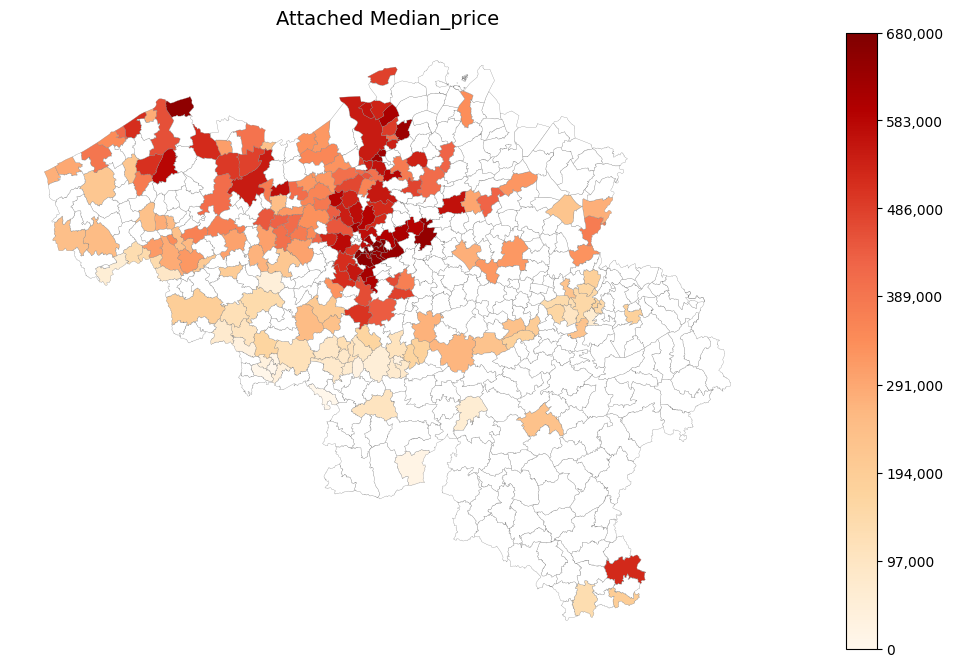

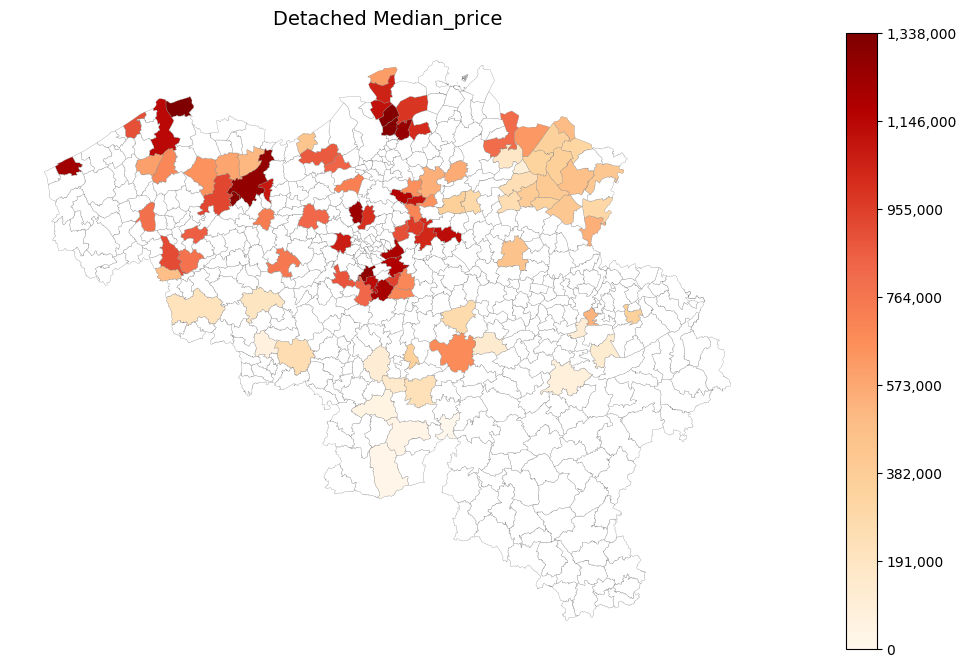

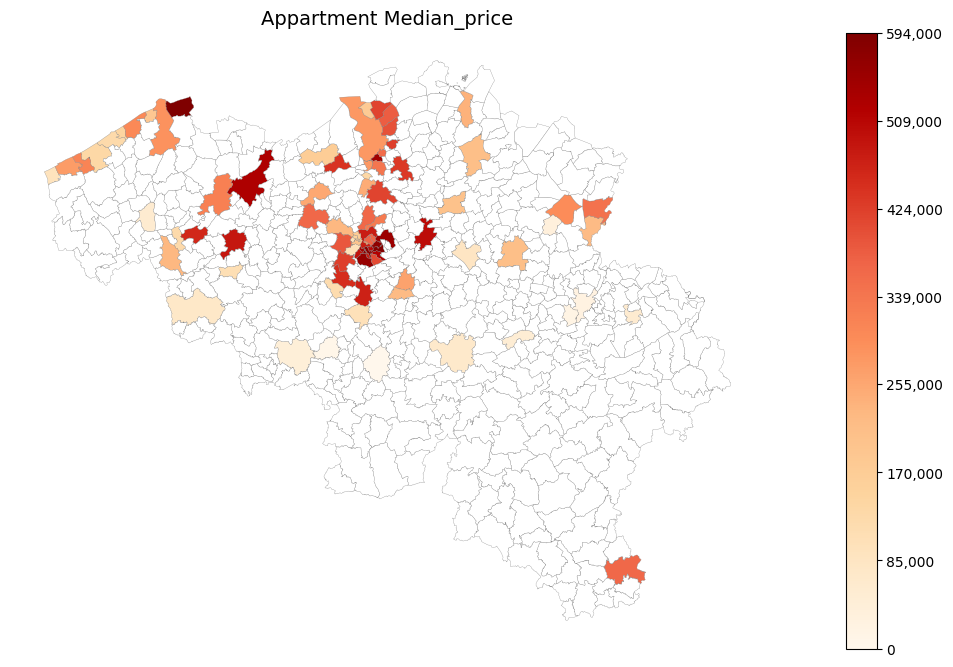

In [68]:
def view_quartile_prices_on_map(df, gdf, t:tuple, quartile):
    cols = [f"q{quartile}_1",f"q{quartile}_2",f"q{quartile}_3"]
    if len(t)==1:
        year = t[0]
        agg = df.groupby(["year","refnis"],group_keys=False)[cols_to_group].apply(weighted_agg).reset_index()
        prices = agg.loc[agg.year==year, ["refnis"]+ cols].copy()
    else:
        year, quarter=t
        agg =df
        prices= agg.loc[(df.year==year) & (df.period==quarter), ["refnis"]+cols].copy()
    
    prices.refnis = prices.refnis.astype(str)
    gdf = gdf.merge(prices, how="left", left_on="cd_munty_refnis", right_on="refnis")
    
    for col in cols:
        vmax = gdf[col].max()
        
        ticks = np.linspace(0, vmax, 8)
        ticks = np.round(ticks, -3)  
        
        title = col_names[col]
        fig, ax = plt.subplots(figsize=(26, 8))
        gdf.plot(
            column=col, cmap="OrRd",        
            linewidth=0.2, edgecolor="grey",
            missing_kwds={
                "color": "white",   
                "label": "No data"
            },
            ax=ax
        )
        ax.set_title(f"{title}", fontsize=14)
        ax.set_axis_off()
    
        sm = plt.cm.ScalarMappable(cmap="OrRd", norm=plt.Normalize(vmin=0, vmax=vmax))
        sm._A = []
        cbar = fig.colorbar(sm, ax=ax, fraction=0.03, pad=0.04)
        cbar.set_ticks(ticks)
        cbar.set_ticklabels([f"{int(t):,}" for t in ticks])
    
        plt.show()
    
    #print("Maps saved as map_p1.png, map_p2.png, map_p3.png")
#view_quartile_prices_on_map(df, gdf, (2024,), 2)
view_quartile_prices_on_map(df, gdf, (2024, "Q1"), 2)